## Toxic comment classification
### Import library

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 42
import os
os.environ['OMP_NUM_THREADS'] = '4'


## Read data set

In [9]:
#path = 'file/'
train = pd.read_csv('toxicity_data/train.csv')
test = pd.read_csv('toxicity_data/test.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (159571, 8)
Number of rows and columns in the test data set: (153164, 2)


In [10]:
raw_train = train

In [11]:
train = train.sample(5000)
#train[train['toxic']==1].values[:5]

In [12]:
raw_test = test

In [13]:
test = test.sample(5000)

## Target varaible distribution

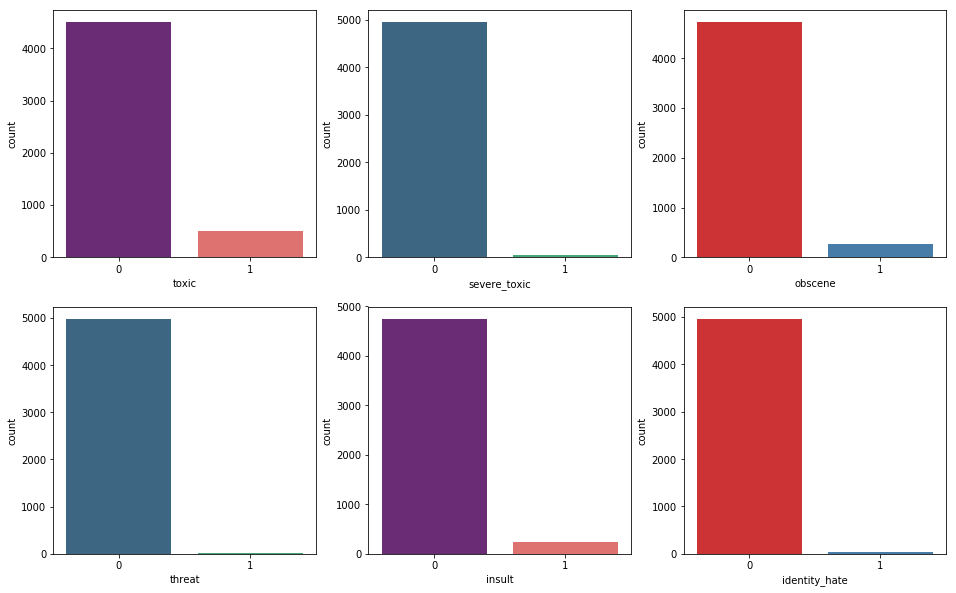

In [14]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6);

## Missing value

In [15]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [16]:
train[train['insult']==1].sample(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
50020,85b332fe1dcac880,YOU ARE A PIECE OF F*CKING SH*T! \n\nf*ck you!...,1,0,1,0,1,0
5973,0ff144ce908dfcba,your a fucking bitch,1,1,1,0,1,0
90439,f2021581f1a60833,what's up asshole bitch,1,0,1,0,1,0
64223,abdc84227a3a3855,"Hey, discofucker, stay out of this.",1,0,1,0,1,0
33006,57d9f06d48f1d4a6,"What a retard, that . Shut your FUD up, you ar...",1,0,0,0,1,0
154683,b17db8251ee78a9d,"Not after, smartass. In case you forgot, I was...",1,0,0,0,1,0
108545,443ddbeaa73d1b0c,I drive a Subaru Legacy and I'm a conservative...,1,0,0,0,1,0
22921,3c92430ef5cbc6c4,"""\n\nYeah, it's definitely true! That sick bas...",1,0,1,0,1,0
91422,f474cfa6f05a85a6,This guy is a Bitch and needs to SUCK a DICK!,1,0,1,0,1,0
116704,6fe74c75edd30218,"""\n\nI heard this fucker was expelled from hig...",1,0,1,0,1,0


In [17]:
test[test['comment_text'].isnull()]

,id,comment_text


In [18]:
test.fillna(' ',inplace=True)
gc.collect()

10116